# **미니프로젝트 4차 1대1 문의 내용 유형 분류기**
# 단계1 : 데이터 탐색

### 문제 정의
> 1:1 문의 내용 분류 문제<br>
> 1. 문의 내용 분석
> 2. 문의 내용 분류 모델 성능 평가
### 학습 데이터
> * 1:1 문의 내용 데이터 : train.csv

### 변수 소개
> * text : 문의 내용
> * label : 문의 유형

### References
> * 한국어 처리
>> * [konlpy - 한국어 처리 라이브러리](https://konlpy.org/ko/latest/)
>> * [한국어 품사 태그 비교표](https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0)
>> * [한국어 품사 태깅 성능 비교](https://konlpy.org/ko/latest/morph/#comparison-between-pos-tagging-classes)
>> * [한국어 시스템 사전](https://konlpy.org/ko/latest/data/#corpora)

> * 자연어 처리
>> * [NLTK](https://www.nltk.org/book/)
>> * [gensim](https://radimrehurek.com/gensim/)
>> * [Google guide](https://developers.google.com/machine-learning/guides/text-classification/step-2)
>> * [WordCloud](https://amueller.github.io/word_cloud/)

## 1. 개발 환경 설정

* 세부 요구사항
  - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
  - 필요하다고 판단되는 라이브러리를 추가하세요.
  - konlpy, mecab 설치 후 형태소 분석 함수 생성

### 1-1. 라이브러리 설치

In [ ]:
# 필요 라이브러리부터 설치할께요.
!pip install konlpy pandas seaborn gensim wordcloud python-mecab-ko wget svgling

In [ ]:
# 런타임 재시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

### 1-2. 라이브러리 import

In [ ]:
from mecab import MeCab
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from wordcloud import WordCloud
from collections import Counter
import wget, os

### 1-3. 한글 글꼴 설정

In [ ]:
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=FONT_PATH, size=10).get_name()
print(font_name)
plt.rcParams['font.family']=font_name
assert plt.rcParams['font.family'] == [font_name], "한글 폰트가 설정되지 않았습니다."

NanumGothic


### 1-4. 구글드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2.데이터 불러오기

### 2-1. 데이터 로딩

* 다음 데이터를 불러옵니다.
    * 학습 및 검증용 데이터 : train.csv
    * shape를 확인합니다.

In [ ]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/content_classification/train.csv')

In [ ]:
train.shape

(3706, 2)

### 2-2. 데이터 확인하기
* 문의 유형 분포 확인
* data type, 결측치 확인

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3706 entries, 0 to 3705
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3706 non-null   object
 1   label   3706 non-null   object
dtypes: object(2)
memory usage: 58.0+ KB


In [ ]:
train.head()

,text,label
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2


In [ ]:
train.isnull().sum()

text     0
label    0
dtype: int64

## 3.데이터 탐색하기


### 3-1. 문의 내용 길이 분포

* 문의 내용의 길이 분포를 확인합니다.
* 최소, 최대 길이의 index 및 문의 내용을 확인합니다.

In [ ]:
train.head()

,text,label
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2


In [40]:
train.tail()

,text,label
3701,"토큰화 이후 train val 를 분리하고 각 train set, val set에 ...",코드2
3702,올린 값들 중 최고점인 건가요? 아니면 최근에 올린 파일로 무조건 갱신인가요?\n최...,시스템 운영
3703,수업에서 cacoo랑 packet tracer를 배우는 이유가\n\n1. IT 인프...,이론
3704,inplace =True 해도 값이 변경이 안되고 none으로 뜹니다. 혹시 원격지...,원격
3705,상관관계는 그렇게 크지 않게 나오는데 p -value 값은 관련이 있게 나오는데 \...,이론


In [ ]:
train['size'] = train['text'].apply(len)
min_index = train['size'].idxmin()
max_index = train['size'].idxmax()
min_text = train.at[min_index, 'text']
max_text = train.at[max_index, 'text']
print("최소 길이의 문의 내용:")
print(min_text)
print(f"최소 길이: {train.at[min_index, 'size']}")
print("\n최대 길이의 문의 내용:")
print(max_text)
print(f"최대 길이: {train.at[max_index, 'size']}")

최소 길이의 문의 내용:
원격 부탁드립니다
최소 길이: 9

최대 길이의 문의 내용:
sns.kdeplot(x = td[var])
plt.show()

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
 in 
----&gt; 1 sns.kdeplot(x = td[var])
      2 plt.show()

~\anaconda3\lib\site-packages\seaborn\_decorators.py in inner_f(*args, **kwargs)
     44             )
     45         kwargs.update({k: arg for k, arg in zip(sig.parameters, args)})
---&gt; 46         return f(**kwargs)
     47     return inner_f
     48 

~\anaconda3\lib\site-packages\seaborn\distributions.py in kdeplot(x, y, shade, vertical, kernel, bw, gridsize, cut, clip, legend, cumulative, shade_lowest, cbar, cbar_ax, cbar_kws, ax, weights, hue, palette, hue_order, hue_norm, multiple, common_norm, common_grid, levels, thresh, bw_method, bw_adjust, log_scale, color, fill, data, data2, warn_singular, **kwargs)
   1768             plot_kws["color"] = color
   1769 
-&gt; 1770         p.plo

In [ ]:
train.drop(['size'],axis=1,inplace=True)

In [20]:
train.head()

,text,label
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2


### 3-2. 명사 추출하고 품사 태깅하기

* konlpy, MeCab을 활용하여 품사 태깅, 명사 추출하기.
* 2개 이상의 형태소 분석기를 Time analysis 해보기
* Number of Samples / Number of words per sample 구해보기

In [ ]:
!pip install konlpy
!pip install mecab-python3
!pip install pandas

In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2023-10-16 03:21:32--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2023-10-16 03:21:32--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0c8f33b07d6c5199606e862202.dl.dropboxusercontent.com/cd/0/get/CFpAY1cOk7mE0M2tNX4vJxZg9hbaWqKf0hC-sgz6IvND_4X32fkUoQ3etfY2cELiQVw7AjxoT9UG6Ki7fJIt2bfa8TxSpmBZRa5QVkqcTw8YoOeNvVtKWxEKJ4wdB4z-sSXQq52aIcESvHH3yCYkrc8N/file?dl=1# [following]
--2023-10-16 03:21:32--  https://uc0c8f33b07d6c5199606e862202.dl.dropboxusercontent.com/cd/0/get/CFpAY1cOk7mE0M2tNX4vJxZg9hbaWqKf0hC-sgz6IvND_4X32fkUoQ3

In [ ]:
import pandas as pd
from konlpy.tag import Kkma, Hannanum
import MeCab
import time

In [43]:
# 두 개 이상의 형태소 분석기를 초기화
kkma = Kkma()
hannanum = Hannanum()
mecab = MeCab.Tagger()
# 시간 측정을 위한 빈 리스트를 초기화
times_kkma = []
times_hannanum = []
times_mecab = []


In [23]:
# # Kkma, Hannanum, MeCab 초기화
# kkma = Kkma()
# mecab = MeCab.Tagger()

# # 샘플 수와 샘플 당 단어 수를 초기화
# num_samples = len(train)
# words_per_sample = []

# # 시간 측정 결과를 저장할 리스트 초기화
# times_kkma = []
# times_mecab = []

# for text in train['text']:
#     # Kkma를 사용한 품사 태깅과 명사 추출 시간 측정
#     start_time = time.time()
#     kkma_nouns = kkma.nouns(text)
#     end_time = time.time()
#     times_kkma.append(end_time - start_time)

#     # MeCab을 사용한 품사 태깅과 명사 추출 시간 측정
#     start_time = time.time()
#     mecab_output = mecab.parse(text)
#     mecab_nouns = [word.split("\t")[0] for word in mecab_output.split("\n") if len(word.split("\t")) == 2]
#     end_time = time.time()
#     times_mecab.append(end_time - start_time)

#     # 샘플 당 단어 수 계산
#     words_per_sample.append(len(text.split()))

# # 시간 측정 결과를 데이터프레임으로 저장
# time_data = pd.DataFrame({
#     'Sample': train['text'],
#     'Kkma_Time': times_kkma,
#     'MeCab_Time': times_mecab
# })

# # 샘플 수와 샘플 당 단어 수 출력
# print(f"Number of Samples: {num_samples}")
# print(f"Number of Words per Sample: {words_per_sample}")

# # 시간 측정 결과 출력
# print(time_data)

Number of Samples: 3706
Number of Words per Sample: [27, 28, 30, 26, 25, 26, 34, 72, 100, 29, 28, 16, 9, 66, 20, 43, 32, 16, 33, 12, 18, 10, 20, 23, 54, 13, 47, 236, 35, 43, 56, 23, 66, 42, 28, 30, 21, 17, 23, 45, 19, 43, 8, 16, 61, 13, 15, 45, 11, 33, 12, 31, 28, 18, 19, 77, 14, 31, 37, 19, 7, 23, 43, 20, 13, 27, 3, 28, 24, 21, 17, 47, 7, 111, 18, 15, 11, 21, 15, 65, 41, 26, 37, 14, 9, 45, 30, 40, 55, 5, 79, 29, 36, 145, 59, 17, 16, 161, 21, 23, 12, 25, 15, 84, 19, 47, 22, 8, 44, 11, 20, 10, 17, 18, 37, 23, 117, 11, 19, 23, 12, 18, 30, 127, 67, 15, 9, 60, 49, 42, 25, 18, 15, 23, 17, 36, 8, 8, 58, 34, 23, 74, 33, 11, 15, 32, 29, 12, 29, 38, 45, 15, 25, 17, 6, 41, 53, 7, 29, 16, 26, 8, 38, 27, 27, 128, 8, 16, 10, 13, 48, 24, 18, 50, 14, 35, 47, 11, 7, 13, 23, 51, 64, 22, 14, 10, 17, 28, 24, 18, 30, 12, 33, 13, 106, 23, 19, 24, 17, 75, 33, 18, 8, 20, 12, 20, 23, 23, 95, 32, 21, 25, 11, 79, 15, 10, 22, 40, 11, 46, 58, 67, 30, 22, 15, 9, 4, 17, 13, 15, 62, 32, 20, 13, 48, 27, 8, 12, 32, 33

In [44]:
# 샘플 수와 샘플 당 단어 수를 초기화
num_samples = len(train)
words_per_sample = []

for text in train['text']:
    # Kkma를 사용한 품사 태깅과 명사 추출 시간 측정
    start_time = time.time()
    kkma_pos = kkma.pos(text)
    kkma_nouns = kkma.nouns(text)
    end_time = time.time()
    times_kkma.append(end_time - start_time)

    # # Hannanum을 사용한 품사 태깅과 명사 추출 시간 측정
    # start_time = time.time()
    # hannanum_pos = hannanum.pos(text)
    # hannanum_nouns = hannanum.nouns(text)
    # end_time = time.time()
    # times_hannanum.append(end_time - start_time)

    # MeCab을 사용한 품사 태깅과 명사 추출 시간 측정
    start_time = time.time()
    mecab_output = mecab.parse(text)
    mecab_pos = [token.split("\t")[1].split(",") for token in mecab_output.split("\n") if len(token.split("\t")) == 2]
    mecab_nouns = [word[0] for word in mecab_pos if word[1] == "NNG" or word[1] == "NNP"]
    end_time = time.time()
    times_mecab.append(end_time - start_time)

    # 샘플 당 단어 수 계산
    words_per_sample.append(len(text.split()))

# 시간 측정 결과를 데이터프레임으로 저장
time_data = pd.DataFrame({
    'Sample': train['text'],
    'Kkma_Time': times_kkma,
    # 'Hannanum_Time': times_hannanum,
    'MeCab_Time': times_mecab
})

# 샘플 수와 샘플 당 단어 수 출력
print(f"Number of Samples: {num_samples}")
print(f"Number of Words per Sample: {words_per_sample}")

# 시간 측정 결과 출력
print(time_data)

KeyboardInterrupt: ignored

In [ ]:
# from konlpy.tag import Mecab
# mecab = Mecab(dicpath="/content/drive/MyDrive/mecap/mecab-ko-dic-2.1.1-20180720/user-dic") #구글드라이브 사전 path지정
# mecab.morphs("아프리카 돼지 열병 아프리카돼지열병")

### 3-3. nltk로 텍스트 분석하기
* 3-2.의 명사 추출, 품사 태깅한 데이터를 nltk Text로 변경하기
* 각각 token 갯수 / 전체 token 비율(Type-Token Ratio) 알아보기
* 각각 Frequency 확인 및 분포 시각화
* 명사 추출한 데이터에서 코드, 웹, 이론, 원격, 시스템 등 관심있는 각 단어에 분석해보기
* 각각 collocation 확인
* 최소 길이 문의 내용에 대해 grammar pasing 해보기(아래 코드 활용)


```python
grammar = """
NP: {<N.*>*<Suffix>?}   # Noun phrase
VP: {<V.*>*}            # Verb phrase
AP: {<A.*>*}            # Adjective phrase
"""
NP_grammar = "NP: {<Adjective>*<Noun>*}"
```

In [25]:
import nltk

# NLTK Text 객체를 만들어주는 함수
def create_nltk_text(nouns):
    return nltk.Text(nouns)

# 명사 추출 및 품사 태깅 데이터를 NLTK Text로 변경
nltk_kkma_text = create_nltk_text(kkma_nouns) #태깅데이터
nltk_mecab_text = create_nltk_text(mecab_nouns)

# NLTK Text 객체 활용 예
print("NLTK Text for Kkma:")
print(nltk_kkma_text)

print("NLTK Text for MeCab:")
print(nltk_mecab_text)

NLTK Text for Kkma:
<Text: 상관관계 값 관련 경우 해석...>
NLTK Text for MeCab:
<Text: 상관 관계 는 그렇게 크 지 않 게...>


In [31]:
!python -m spacy download ko_core_news_sm

2023-10-16 05:06:14.805125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 91.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ko_core_news_sm')


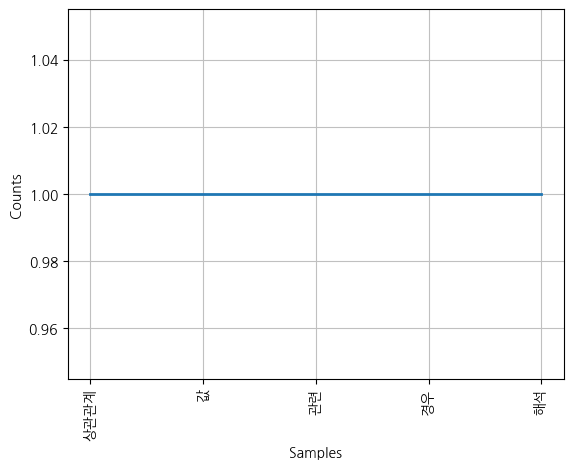

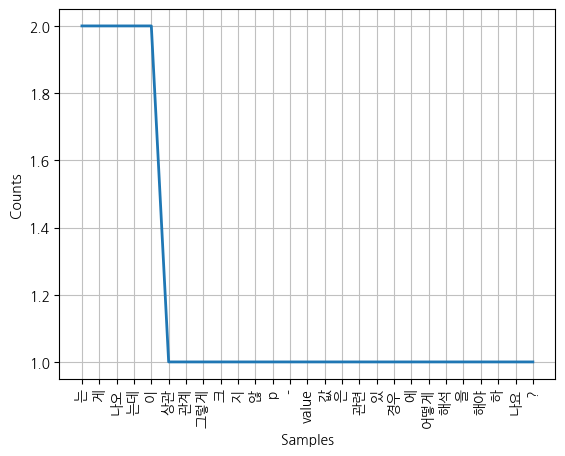

원격 PROPN compound
부탁드립니다 NOUN ROOT
Frequency of '코드' (Kkma): 0
Frequency of '코드' (MeCab): 0
Frequency of '웹' (Kkma): 0
Frequency of '웹' (MeCab): 0
Frequency of '이론' (Kkma): 0
Frequency of '이론' (MeCab): 0
Frequency of '원격' (Kkma): 0
Frequency of '원격' (MeCab): 0
Frequency of '시스템' (Kkma): 0
Frequency of '시스템' (MeCab): 0
Collocations (Kkma): [('값', '관련'), ('경우', '해석'), ('관련', '경우'), ('상관관계', '값')]
Collocations (MeCab): [('게', '나오'), ('나오', '는데'), ('-', 'value'), ('p', '-'), ('value', '값'), ('값', '은'), ('경우', '에'), ('그렇게', '크'), ('나요', '?'), ('상관', '관계')]


In [32]:
import nltk
from nltk import FreqDist
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

# 명사 추출 및 품사 태깅 데이터를 NLTK Text 객체로 만들기
nltk_kkma_text = nltk.Text(kkma_nouns)
nltk_mecab_text = nltk.Text(mecab_nouns)

# Token 개수 구하기
token_count_kkma = len(nltk_kkma_text)
token_count_mecab = len(nltk_mecab_text)

# Type-Token Ratio (TTR) 계산
ttr_kkma = len(set(nltk_kkma_text)) / token_count_kkma
ttr_mecab = len(set(nltk_mecab_text)) / token_count_mecab

# Frequency 확인 및 분포 시각화
# 빈도 분포 확인
freq_dist_kkma = FreqDist(nltk_kkma_text)
freq_dist_mecab = FreqDist(nltk_mecab_text)

# 가장 빈도가 높은 단어들 출력
top_words_kkma = freq_dist_kkma.most_common(10)
top_words_mecab = freq_dist_mecab.most_common(10)

# 단어 분포 시각화
freq_dist_kkma.plot(30, cumulative=False)
freq_dist_mecab.plot(30, cumulative=False)

# Collocation 확인
bigram_measures = BigramAssocMeasures()
finder_kkma = BigramCollocationFinder.from_words(kkma_nouns)
collocations_kkma = finder_kkma.nbest(bigram_measures.likelihood_ratio, 10)

finder_mecab = BigramCollocationFinder.from_words(mecab_nouns)
collocations_mecab = finder_mecab.nbest(bigram_measures.likelihood_ratio, 10)

# 문법 파싱 (파싱 라이브러리 필요)
# 여기서는 파싱 라이브러리로 spaCy를 사용하는 예제를 보여드립니다.
import spacy

# # spaCy 모델 로드
nlp = spacy.load("ko_core_news_sm")

# 최소 길이 문의 내용
min_length_text = min_text

# 문법 파싱
parsed_text = nlp(min_length_text)

# 파싱 결과 출력
for token in parsed_text:
    print(token.text, token.pos_, token.dep_)

# 원하는 관심 단어들에 대한 분석 수행
# 예를 들어, "코드", "웹", "이론", "원격", "시스템" 등의 관심 단어에 대한 분석 수행
interest_words = ["코드", "웹", "이론", "원격", "시스템"]
for word in interest_words:
    # 특정 단어의 빈도 확인
    freq_word_kkma = freq_dist_kkma[word]
    freq_word_mecab = freq_dist_mecab[word]
    print(f"Frequency of '{word}' (Kkma): {freq_word_kkma}")
    print(f"Frequency of '{word}' (MeCab): {freq_word_mecab}")

# Collocation 확인
print("Collocations (Kkma):", collocations_kkma)
print("Collocations (MeCab):", collocations_mecab)

In [42]:
"""
토큰의 빈도수는 특정 단어(토큰)이 얼마나 자주 나타나는지를 의미하고
collocation은 특정 문맥에서 한단어를 중심으로 앞뒤로 지정한 window size만큼
함께 자주 나타나는 단어를 의미합니다.

예를들어 토큰의 빈도수가 만약 [문제 연습 테스트 데이터 정답] 이런식으로 나왔는데
collocation으로 데이터 프레임; 테스트 케이스; 문자열 변수; (collocation은 ;로 한쌍씩 구성됩니다)
이라고 나왔다면, collocation을 통해 프로그래밍 주제의 문맥으로 이루어진 텍스트임을 유추 할 수 있는 것과 같이 자연어 처리에서 쓰입니다.
"""

'\n토큰의 빈도수는 특정 단어(토큰)이 얼마나 자주 나타나는지를 의미하고\ncollocation은 특정 문맥에서 한단어를 중심으로 앞뒤로 지정한 window size만큼\n함께 자주 나타나는 단어를 의미합니다.\n\n예를들어 토큰의 빈도수가 만약 [문제 연습 테스트 데이터 정답] 이런식으로 나왔는데\ncollocation으로 데이터 프레임; 테스트 케이스; 문자열 변수; (collocation은 ;로 한쌍씩 구성됩니다)\n이라고 나왔다면, collocation을 통해 프로그래밍 주제의 문맥으로 이루어진 텍스트임을 유추 할 수 있는 것과 같이 자연어 처리에서 쓰입니다.\n'

In [34]:
from konlpy.tag import Okt

okt = Okt()

okt.morphs('한글 형태소 분석기(오케이티)로 테스트를 해보았습니다. 정상 설치 및 동작이 잘 됩니다.')

['한글',
 '형태소',
 '분석',
 '기',
 '(',
 '오',
 '케이티',
 ')',
 '로',
 '테스트',
 '를',
 '해보았습니다',
 '.',
 '정상',
 '설치',
 '및',
 '동작',
 '이',
 '잘',
 '됩니다',
 '.']

In [36]:
# 주어진 문법 규칙 설정
grammar = """
NP: {<N.*>*<Suffix>?}   # Noun phrase
VP: {<V.*>*}            # Verb phrase
AP: {<A.*>*}            # Adjective phrase
"""
NP_grammar = "NP: {<Adjective>*<Noun>*}"

# 문법 파서 생성
parser = nltk.RegexpParser(grammar)

# 최소 길이 문장 설정
min_length_text = min_text

# 구문 분석 수행 (Kkma에서 추출한 명사 활용)
kkma_min_length_text = collocations_kkma
kkma_sentence = [(word, 'Noun') for word in kkma_nouns]
kkma_tree = parser.parse(kkma_sentence)

# 구문 분석 결과 출력
kkma_tree.pretty_print()

                    S                   
                    |                    
                    NP                  
     _______________|_______________     
상관관계/Noun 값/Noun 관련/Noun 경우/Noun 해석/Noun



### 3-4. Wordcloud 만들기
* 명사 추출/형태소 분석 결과를 이용하여 WordCloud 객체를 생성
* 최대 글꼴 크기(max_font_size), 최대 단어 수(max_words), 배경 색상(background_color)
* 상대 크기비율(relative_scaling), 그림 크기(width, height), 폰트 경로(font_path=FONT_PATH) 등 설정
* .generate 메서드를 연결하여 WordCloud에 사용될 텍스트 데이터 생성
* plt.imshow(  ) 를 통해 화면에 보여집니다.

In [39]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# font_name = fm.FontProperties(fname=FONT_PATH, size=10).get_name()
# print(font_name)
# plt.rcParams['font.family']=font_name
# assert plt.rcParams['font.family'] == [font_name], "한글 폰트가 설정되지 않았습니다."

# 필요한 설정 값들 정의
max_font_size = 60
max_words = 100
background_color = 'white'
relative_scaling = 0.5
width = 800
height = 400
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 사용할 폰트 파일 경로

# 텍스트 데이터 (예시)
text_data = nltk_kkma_text

# WordCloud 객체 생성 및 설정
wordcloud = WordCloud(
    max_font_size=max_font_size,
    max_words=max_words,
    background_color=background_color,
    relative_scaling=relative_scaling,
    width=width,
    height=height,
    font_path=font_path
)

# 텍스트 데이터로 WordCloud 생성
wordcloud.generate(text_data)

# 시각화
plt.figure(figsize=(10, 5))  # 워드클라우드 이미지 크기 설정
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축 비활성화
plt.show()

TypeError: ignored

In [41]:
####한국어 형태소 분석기####
from konlpy.tag import Kkma, Komoran, Okt, Hannanum #Mecab은 윈도우에서 작동 불가능
okt = Okt()
kkma = Kkma()
komoran = Komoran()
hannanum = Hannanum()

text = '나랏말이 중국과 달라 한자와 서로 통하지 아니하므로, \
    우매한 백성들이 말하고 싶은 것이 있어도 마침내 제 뜻을 잘 표현하지 못하는 사람이 많다.\
    내 이를 딱하게 여기어 새로 스물여덟 자를 만들었으니, \
    사람들로 하여금 쉬 익히어 날마다 쓰는 데 편하게 할 뿐이다.'

#### .morphs()함수: 텍스트를 형태소 단위로 나누어준다.####
print("[Kkma morphs 함수]")
print(kkma.morphs(text))
print("[Okt 함수]")
print(okt.morphs(text))
print("[Komoran 함수]")
print(komoran.morphs(text))
print("[Hannanum 함수]")
print(hannanum.morphs(text))

##### stem: 각 단어에서 어간 추출 #####
print("[Okt 함수: stem사용하여 어간 추출]")
print(okt.morphs(text, stem= True))

#### .nouns()함수: 명사를 추출 ####
print("[Kkma nouns 함수]")
print(kkma.nouns(text))
print("[OKt nouns 함수]")
print(okt.nouns(text))
print("[Komoran nouns 함수]")
print(komoran.nouns(text))
print("[Hannanum nouns 함수]")
print(hannanum.nouns(text))

#### .phrases()함수: 어절 추출 ####
print("[Okt phrases 함수]")
print(okt.phrases(text))

#### .pos()함수: 품사 태깅 ####
print("[Kkma pos 함수]")
print(kkma.pos(text)) #join=True는 형태소와 품사를 붙여서 리스트화
print("[Okt pos 함수]")
print(okt.pos(text))
print("[Komoran pos 함수]")
print(komoran.pos(text))
print("[Hannanum pos 함수]")
print(hannanum.pos(text))

[Kkma morphs 함수]
['나랏말', '이', '중국', '과', '닿', 'ㄹ라', '한자', '와', '서로', '통하', '지', '아니하', '므로', ',', '우매', '하', 'ㄴ', '백성', '들', '이', '말하', '고', '싶', '은', '것', '이', '있', '어도', '마침내', '저', '의', '뜻', '을', '잘', '표현', '하', '지', '못하', '는', '사람', '이', '많', '다', '.', '내', '이르', 'ㄹ', '딱하', '게', '여기', '어', '새로', '스물', '여덟', '자', '를', '만들', '었', '으니', ',', '사람', '들', '로', '하여금', '쉬', '익히', '어', '날', '마다', '쓰', '는', '데', '편하', '게', '하', 'ㄹ', '뿐', '이', '다', '.']
[Okt 함수]
['나랏말', '이', '중국', '과', '달라', '한자', '와', '서로', '통', '하지', '아니하므로', ',', '우매', '한', '백성', '들', '이', '말', '하고', '싶은', '것', '이', '있어도', '마침내', '제', '뜻', '을', '잘', '표현', '하지', '못', '하는', '사람', '이', '많다', '.', '내', '이를', '딱하게', '여기어', '새로', '스물', '여덟', '자를', '만들었으니', ',', '사람', '들', '로', '하여금', '쉬', '익히어', '날', '마다', '쓰는', '데', '편하게', '할', '뿐', '이다', '.']
[Komoran 함수]
['나랏말이', '중국', '과', '다르', '아', '한자', '와', '서로', '통하', '지', '아니하', '므로', ',', '우매', '하', 'ㄴ', '백성', '들', '이', '말', '하', '고', '싶', '은', '것', '이', '있', '어도', '마침내', '제', '뜻', '을

## 4. 문의 유형에 따른 분석
### 4-1. *3. 데이터 탐색*에서 실행한 알고리즘을 문의 유형에 따라 실행할 수 있는 함수를 개발합니다.
* 아래 text_analysis 함수를 개발합니다.

In [ ]:
def text_analysis(df, label=None):
    """
    label에 따라서 분석, label이 None인 경우 전체 분석
    데이터 확인, 데이터 길이 시각화
    명사 추출하여 분석, 워드 클라우드 시각화

    Parameters
    ----------
    df : pandas DataFrame object.
    label : Label for analysis, default=None.
    - If label is None, Entire data are analyzed.

    Returns
    -------
    result : None

    """
    pass

### 4-2. 각각의 문의 유형에 대해 실행합니다.

In [ ]:
for label in sorted(train_df.label.unique()):
    text_analysis(train_df,label)

# 단계2 : 데이터 전처리
> * Tokenization(Konlpy...)
> * Vectorization(N-grams, Sequence)
> * [Google guide](https://developers.google.com/machine-learning/guides/text-classification/step-3)

## 5. 데이터 준비
### 5-1. label 아래 형식으로 처리
```python
label_dict = {
    '코드1': 0,
    '코드2': 0,
    '웹': 1,
    '이론': 2,
    '시스템 운영': 3,
    '원격': 4
}
```

### 5-2. Train Validation split

## 6. 데이터 처리

### 6-1. 특수문자 제거(Optional)
- [정규표현식 이용](https://docs.python.org/3/howto/regex.html)

### 6-2. N-grams (sklearn)
> * [scikit-learn working with text data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#)
> * [scikit-learn text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
> * [한글 자료](https://datascienceschool.net/03%20machine%20learning/03.01.03%20Scikit-Learn%EC%9D%98%20%EB%AC%B8%EC%84%9C%20%EC%A0%84%EC%B2%98%EB%A6%AC%20%EA%B8%B0%EB%8A%A5.html)

### 6-3. Sequence (keras, whatever)
> * [keras text classification](https://keras.io/examples/nlp/text_classification_from_scratch/)
> * [tensorflow text classification](https://www.tensorflow.org/tutorials/keras/text_classification)
* tokenizer.fit_on_texts() : 주어진 텍스트 데이터에 대해 단어 사전 생성
* 문장 길이 분포 살펴보기
* 문장 길이를 구해서 기초통계량, histogram, boxplot을 그려보고 적절한 개수를 결정합니다.
* tokenizer.texts_to_sequences() : 주어진 텍스트 데이터를 정수 시퀀스로 변환

### 6-4. Word2Vec (gensim, optional)
> * [gensim-word2vec-tutorial](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py)
> * [tensorflow-word2vec-tutorial](https://www.tensorflow.org/tutorials/text/word2vec?hl=ko)

In [ ]:
# 아래 함수는 제공합니다.
def get_sent_embeddings(model, embedding_size, tokenized_words):

    # 단어 임베딩 및 n_words의 크기가 0인 feature_vec 배열을 0으로 초기화합니다.
    # 또한 model.wv.index2word를 사용하여 Word2Vec 모델의 어휘에 단어 세트를 생성합니다.
    feature_vec = np.zeros((embedding_size,), dtype='float32')
    n_words = 0
    index2word_set = set(model.wv.index_to_key)

    # 토큰화된 문장의 각 단어를 반복하고 Word2Vec 모델의 어휘에 존재하는지 확인합니다.
    # 그렇다면 n_words가 증가하고 단어의 임베딩이 feature_vec에 추가됩니다.
    for word in tokenized_words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])

    # Word2Vec 모델의 어휘에 있는 입력 문장에 단어가 있는지 확인합니다.
    # 있다면 feature_vec를 n_words로 나누어 입력 문장의 평균 임베딩을 구합니다.
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)

    return feature_vec
def get_dataset(sentences, model, num_features):

    # 각 문장에 대한 임베딩을 보유할 dataset이라는 빈 목록을 초기화합니다.
    dataset = list()

    # 문장의 각 문장을 반복하고 앞에서 설명한 get_sent_embeddings() 함수를 사용하여 문장에 대한 평균 임베딩을 생성합니다.
    # 결과 문장 임베딩이 데이터 세트 목록에 추가됩니다.
    for sent in sentences:
        dataset.append(get_sent_embeddings(model, num_features, sent))

    # 루프에서 생성된 문장 임베딩을 sent_embedding_vectors라는 2차원 배열에 쌓습니다.
    sent_embedding_vectors = np.stack(dataset)

    return sent_embedding_vectors

### 6-5. 데이터 저장하기
* N-gram, Sequence로 처리한 데이터 저장
* sparse data에 대해서는 scipy.sparse.save_npz 활용